# Implicitly defined reachable sets within GCS

In [ ]:
import numpy as np
from large_gcs.graph_generators.hor_vert_gcs import create_simplest_hor_vert_graph

# from explorations.hor_vert_gcs_bug import create_simplest_hor_vert_graph

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

## Simple Example Graph

In [ ]:
g = create_simplest_hor_vert_graph()
g.plot_sets()
g.plot_edges()
g.plot_set_labels()

In [ ]:
sol = g.solve_shortest_path()
g.plot_sets()
g.plot_edges()
g.plot_path(sol.ambient_path)

In [ ]:
print(g.edge_keys)
sol_conv_res = g.solve_convex_restriction([("s", "p1"), ("p1", "p2"), ("p2", "t")])

sol_conv_res
g.plot_sets()
g.plot_path(sol_conv_res.ambient_path)

In [ ]:
for vertex_name, v in g.vertices.items():
    print(vertex_name, v.gcs_vertex.set().IsBounded())

# Sampling Procedure
To determine if A is dominated by B

In [ ]:
# Sample 100 points in p2
p2_samples = np.array(g.vertices["p2"].convex_set.get_samples(100))
g.plot_sets()
g.plot_points(p2_samples)

In [ ]:
# Project these samples into revised set based on path


def project_sample_to_revised_set(sample, vertex_sampled, active_edges):
    prog = MathematicalProgram()
    vertex_names = [active_edges[0][0]] + [edge[1] for edge in active_edges]
    # gcs vertices
    vertices = [g.vertices[name].gcs_vertex for name in vertex_names]
    edges = [g.edges[edge].gcs_edge for edge in active_edges]
    for v in vertices:
        if v.set().ambient_dimension() == 0:
            continue
        prog.AddDecisionVariables(v.x())
        v.set().AddPointInSetConstraints(prog, v.x())

        # Vertex Costs
        for binding in v.GetCosts():
            prog.AddCost(binding)
        # Vertex Constraints
        for binding in v.GetConstraints():
            prog.AddConstraint(binding)

    for e in edges:
        # Edge Costs
        for binding in e.GetCosts():
            prog.AddCost(binding)
        # Edge Constraints
        for binding in e.GetConstraints():
            prog.AddConstraint(binding)

    result = Solve(prog)
    if not result.is_success():
        raise RuntimeError("Failed to solve")
    return result


# active_edges = [("s", "p1"), ("p1", "p2")]
active_edges = [("s", "p1"), ("p1", "p2"), ("p2", "t")]
res = project_sample_to_revised_set(p2_samples[0], "p2", active_edges)
print(f"optimal_cost: {res.get_optimal_cost()}")
print(sol.cost)

# GcsAstarReachability

In [1]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
import numpy as np

from large_gcs.graph_generators.hor_vert_gcs import create_simplest_hor_vert_graph, create_polyhedral_hor_vert_graph
# from explorations.hor_vert_gcs_bug import create_simplest_hor_vert_graph

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

In [4]:
# g = create_simplest_hor_vert_graph()
g = create_polyhedral_hor_vert_graph()
cost_estimator_se = ShortcutEdgeCE(g, shortcut_edge_cost_factory)
alg = GcsAstarReachability(g, cost_estimator_se, num_samples_per_vertex=100)
sol = alg.run()

INFO:large_gcs.graph.graph:Adding 5 vertices to graph...
100%|██████████| 5/5 [00:00<00:00, 21777.28it/s]
INFO:large_gcs.algorithms.gcs_astar_reachability:Running GcsAstarReachability
INFO:large_gcs.algorithms.gcs_astar_reachability:exploring edge s -> p0
DEBUG:large_gcs.cost_estimators.shortcut_edge_ce:conv_res_active_edges: ["('s', 'p0')", "('p0', 't')_shortcut"]
DEBUG:large_gcs.graph.graph:active edge keys: ["('s', 'p0')", "('p0', 't')_shortcut"]
DEBUG:large_gcs.graph.graph:is_success: True
DEBUG:large_gcs.cost_estimators.shortcut_edge_ce:Removing edge ('p0', 't')_shortcut
DEBUG:large_gcs.algorithms.gcs_astar_reachability:edge s -> p0 is feasible
DEBUG:large_gcs.algorithms.gcs_astar_reachability:Adding samples for p0
DEBUG:large_gcs.algorithms.gcs_astar_reachability:reaches new, active edges: ["('s', 'p0')", "('p0', 'p0_sample_0')"]
DEBUG:large_gcs.graph.graph:active edge keys: ["('s', 'p0')", "('p0', 'p0_sample_0')"]
DEBUG:large_gcs.graph.graph:is_success: True
DEBUG:large_gcs.algo

In [3]:
str(sol)

"is_success: True, cost: 10.8, time: 0.000546, vertex_path: ['s', 'p1', 'p2', 't'], ambient_path: [0.5, 0.5],[0.5, 3.9],[4.5, 3.9],[4.5, 0.5],, flows: [], result: <pydrake.solvers.MathematicalProgramResult object at 0x7f31d82ea8b0>"

In [ ]:
# g.edges["('p0', 'p0_sample_1')"]

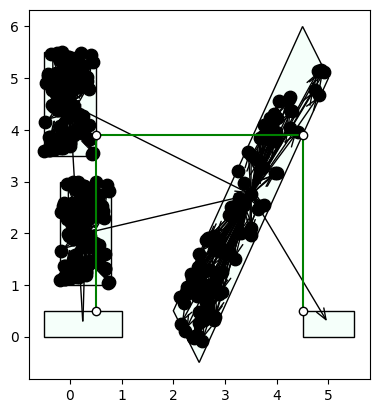

In [6]:
g.plot_sets()
g.plot_edges()
# g.plot_set_labels()
g.plot_path(sol.ambient_path)

In [ ]:
# sol = g.solve_convex_restriction([('s', 'p1'), ('p1', 'p1_sample_0')])
sol = g.solve_convex_restriction([("s", "p1"), ("p1", "p2"), ("p2", "t")])

In [2]:
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction

g = create_polyhedral_hor_vert_graph()
cost_estimator_se = ShortcutEdgeCE(g, shortcut_edge_cost_factory)
alg = GcsAstarConvexRestriction(g, cost_estimator_se)
sol = alg.run()

INFO:large_gcs.graph.graph:Adding 5 vertices to graph...
100%|██████████| 5/5 [00:00<00:00, 29662.69it/s]
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_expanded: {0: 2}, n_vertices_visited: {0: 0}, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}
now exploring node s's 2 neighbors (0)
DEBUG:large_gcs.graph.graph:active edge keys: ["('s', 'p0')", "('p0', 't')"]
DEBUG:large_gcs.graph.graph:is_success: True
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge s -> p0 is feasible, new dist: 4.233630921408221, added to pq True
DEBUG:large_gcs.graph.graph:active edge keys: ["('s', 'p1')", "('p1', 't')"]
DEBUG:large_gcs.gra

Note how GcsAstarConvexRestriction fails because it doesn't have the sampling to determine reachability procedure that GcsAstarReachability has